In [1]:
import torch
import torchvision
from torchvision import transforms
from skimage import io, transform
from torch import nn

import json

import numpy as np

from training.losses import *
from training.train import *
from training.plots import *
from models.gan import *
from models.classifier import *

import matplotlib.pyplot as plt
from PIL import Image
from importlib import reload

In [2]:
BATCH_SIZE = 128
LR = 3e-4
BETAS = 0.9, 0.999

In [3]:
data = torchvision.datasets.MNIST("./../data/mnist", download=True, train=True, transform=lambda x: torch.tensor(transform.resize(np.array(x), (10, 10))).unsqueeze(0))
train_data = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, drop_last=True)

In [4]:
base_classifier = SimpleClassifier()

In [5]:
optimizer = torch.optim.Adam(base_classifier.parameters(), lr=LR, betas=BETAS)
criterion = nn.CrossEntropyLoss()

In [6]:
base_classifier_trainer = BaseClassifierTrainer(base_classifier, criterion, optimizer, 'cpu')

In [7]:
base_res = base_classifier_trainer.train(train_data, 10)

Epoch: 0, Loss: 0.5821471776112787
Epoch: 1, Loss: 0.15672196987538767
Epoch: 2, Loss: 0.10376819578381494
Epoch: 3, Loss: 0.083834623094075
Epoch: 4, Loss: 0.07091161996548057
Epoch: 5, Loss: 0.06199404895086733
Epoch: 6, Loss: 0.05530475547664568
Epoch: 7, Loss: 0.04911064737353028
Epoch: 8, Loss: 0.04450223555700838
Epoch: 9, Loss: 0.04068902952887086


In [8]:
data = torchvision.datasets.MNIST("./../data/mnist", download=True, train=False, transform=lambda x: torch.tensor(transform.resize(np.array(x), (10, 10))).unsqueeze(0))
train_data = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, drop_last=True)

In [9]:
generator_model = Generator()
discriminator_model = Discriminator()
attacked_model = base_classifier.eval()

In [10]:
generator_optimizer = torch.optim.Adam(generator_model.parameters(), lr=LR, betas=BETAS)
discriminator_optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=LR, betas=BETAS)

In [11]:
trainer = Trainer(generator_model, discriminator_model, attacked_model,
                  GANLoss(BATCH_SIZE, 'cpu'),
                  AttackLoss(attacked_model, BATCH_SIZE, 'cpu'),
                  HingeLoss(attacked_model, BATCH_SIZE, 'cpu'),
                  discriminator_optimizer, generator_optimizer, 'cpu')

In [12]:
res = trainer.train(train_data, 10)

Epoch: 0, Generator loss: 0.5938803744621766, Discriminator loss: 1.3322116289383326, Model loss: -1.9170155754456153, Hinge loss: 2.8805669515560837,
Epoch: 1, Generator loss: 0.614814811027967, Discriminator loss: 1.293812939753899, Model loss: -2.2176476472463365, Hinge loss: 2.873957206041385,
Epoch: 2, Generator loss: 0.6328156116681222, Discriminator loss: 1.2675468860528407, Model loss: -2.3232816488314896, Hinge loss: 2.876794310716482,
Epoch: 3, Generator loss: 0.6541409691174825, Discriminator loss: 1.2454080489965587, Model loss: -2.37631688056848, Hinge loss: 2.8726797562379103,
Epoch: 4, Generator loss: 0.6773046919932733, Discriminator loss: 1.2239721646675696, Model loss: -2.4111801966642723, Hinge loss: 2.86919349584824,
Epoch: 5, Generator loss: 0.6905597532406832, Discriminator loss: 1.212418599006457, Model loss: -2.439126763588343, Hinge loss: 2.867567649254432,
Epoch: 6, Generator loss: 0.6975945295431675, Discriminator loss: 1.2049478384164662, Model loss: -2.4629

In [13]:
val_batch = iter(train_data).next()
for i in range(16):
    print(F.softmax(attacked_model(val_batch[0].float()), -1).cpu().detach().numpy()[i, val_batch[1][i]], F.softmax(attacked_model(val_batch[0].float() + generator_model(val_batch[0].float())), -1).cpu().detach().numpy()[i, val_batch[1][i]])
    print(val_batch[1][i])

0.9999963 0.0018085284
tensor(7)
0.9976451 0.002288829
tensor(2)
0.9995715 0.009920733
tensor(1)
0.99806064 0.004323008
tensor(0)
0.99731356 0.0017292276
tensor(4)
0.99987066 0.0050104177
tensor(1)
0.9988237 0.0075793173
tensor(4)
0.9906943 0.00556953
tensor(9)
0.7187204 0.0092216
tensor(5)
0.9991242 0.004581361
tensor(9)
0.99971956 0.010505952
tensor(0)
0.9997764 0.006929886
tensor(6)
0.999729 0.0004551161
tensor(9)
0.9999356 0.0023149948
tensor(0)
0.9999646 0.010285877
tensor(1)
0.99910283 0.04224874
tensor(5)


Text(0.5, 1.0, 'Fake: Prediction: 3, confidence: 0.9814454913139343')

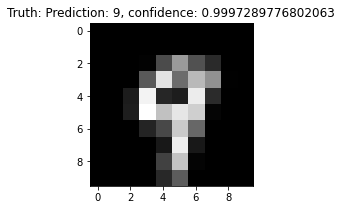

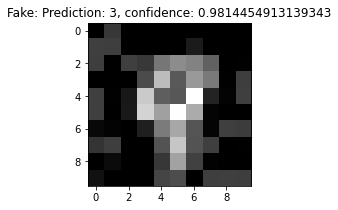

In [21]:
test_img = val_batch[0].float()[12:13]
true_confs = F.softmax(attacked_model(test_img), -1).cpu().detach().numpy()[0]
fake_confs = F.softmax(attacked_model(test_img + generator_model(test_img)), -1).cpu().detach().numpy()[0]

plt.figure(figsize=(3,3))
plt.imshow(test_img[0, 0] * 127.5 + 127.5, cmap='gray')
plt.title("Truth: Prediction: {}, confidence: {}".format(np.argmax(true_confs), true_confs.max()))

plt.figure(figsize=(3,3))
plt.imshow((test_img + generator_model(test_img).cpu().detach().numpy())[0,  0] * 127.5 + 127.5, cmap='gray')
plt.title("Fake: Prediction: {}, confidence: {}".format(np.argmax(fake_confs), fake_confs.max()))

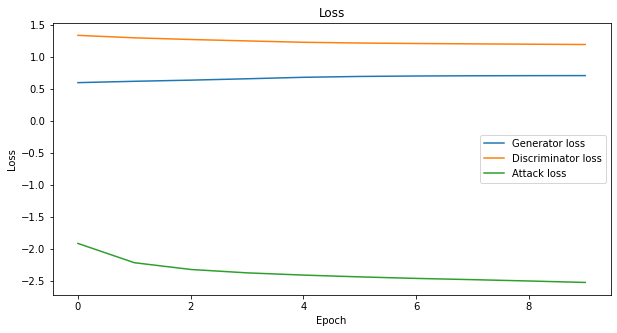

In [15]:
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(res[0],label="Generator loss")
plt.plot(res[1],label="Discriminator loss")
plt.plot(res[2],label="Attack loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()